## Custom Transformer Model

Classes: ['-1' '0' '1']


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_layer (EmbeddingLayer)     │ (None, 300, 64)             │       1,619,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_layer (EncoderLayer)         │ (None, 300, 64)             │          41,148 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 60)                  │           3,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             183 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,664,431 (6.35 MB)

 Trainable params: 1,664,431 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.6522 - loss: 0.7537 - val_accuracy: 0.9374 - val_loss: 0.1945
Epoch 2/5
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.9564 - loss: 0.1436 - val_accuracy: 0.9569 - val_loss: 0.1403
Epoch 3/5
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.9680 - loss: 0.0982 - val_accuracy: 0.9583 - val_loss: 0.1433
Epoch 4/5
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9771 - loss: 0.0705 - val_accuracy: 0.9520 - val_loss: 0.1582
Epoch 5/5
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9823 - loss: 0.0533 - val_accuracy: 0.9557 - val_loss: 0.1874
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Shape of learned_embedding: (1, 300, 64)


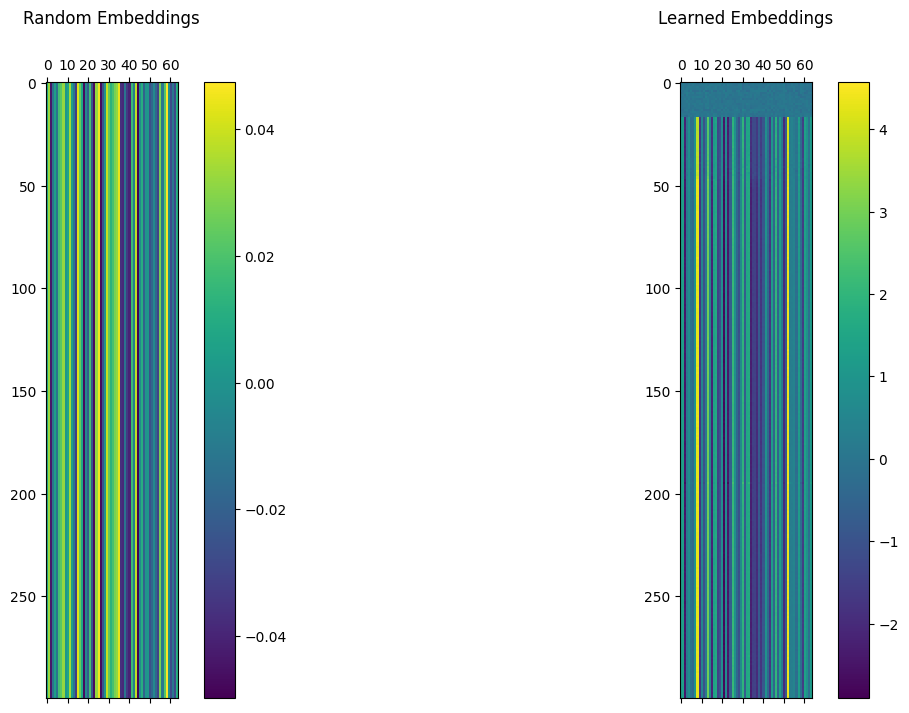

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9563 - loss: 0.1891
Validation Accuracy: 0.9557


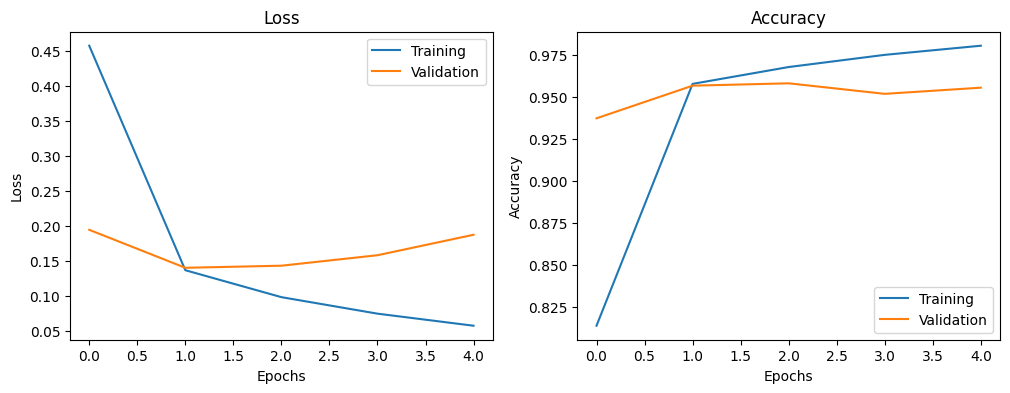

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


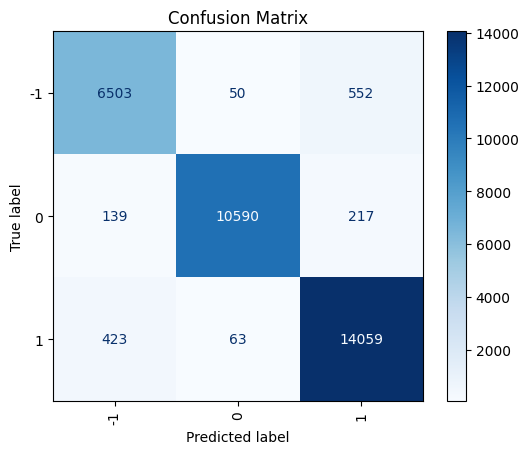

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense, Embedding, GlobalAveragePooling1D, LayerNormalization, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from tensorflow.data import Dataset
from tensorflow import convert_to_tensor, string, float32, shape, range, reshape

# Load dataset
file_path = 'Twitter_Data.csv'
data = pd.read_csv(file_path)

# Drop rows with missing cleaned_text
data = data.dropna(subset=['tweets'])

# Extract features and labels
texts = data['tweets'].astype(str).values
labels = data['label'].astype(str).values

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Get class names
class_names = label_encoder.classes_
print("Classes:", class_names)

# Define parameters
vocab_size = 25000
sequence_length = 300

# Vectorization layer
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length
)

# Adapt vectorizer to texts
vectorize_layer.adapt(Dataset.from_tensor_slices(texts))

# Vectorize text data
texts_vectorized = vectorize_layer(convert_to_tensor(texts, dtype=string))

class EmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super(EmbeddingLayer, self).__init__()
        self.word_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, tokens):
        sequence_length = shape(tokens)[-1]
        positions = range(start=0, limit=sequence_length, delta=1)
        positions_encoding = self.position_embedding(positions)
        words_encoding = self.word_embedding(tokens)
        return positions_encoding + words_encoding

class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim):
        super(EncoderLayer, self).__init__()
        self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)
        self.nnw = Sequential([Dense(total_dense_units, activation="relu"), Dense(embed_dim)])
        self.normalize_layer = LayerNormalization()

    def call(self, inputs):
        attn_output = self.multihead(inputs, inputs)
        normalize_attn = self.normalize_layer(inputs + attn_output)
        nnw_output = self.nnw(normalize_attn)
        final_output = self.normalize_layer(normalize_attn + nnw_output)
        return final_output

# Model parameters
embed_dim = 64
num_heads = 2
total_dense_units = 60

# Define the model
inputs = Input(shape=(sequence_length,))
embedding_layer = EmbeddingLayer(sequence_length, vocab_size, embed_dim)
encoder_layer = EncoderLayer(num_heads, total_dense_units, embed_dim)
emb = embedding_layer(inputs)
enc = encoder_layer(emb)
pool = GlobalAveragePooling1D()(enc)
dense = Dense(total_dense_units, activation="relu")(pool)
outputs = Dense(len(class_names), activation="softmax")(dense)

transformer_model = Model(inputs=inputs, outputs=outputs)
transformer_model.compile(optimizer="adamw", loss="categorical_crossentropy", metrics=['accuracy'])
transformer_model.summary()

# Split data into train and validation
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy

# Convert the TensorFlow tensor to a NumPy array
texts_vectorized_np = texts_vectorized.numpy()

# Now perform the split
X_train, X_val, y_train, y_val = train_test_split(
    texts_vectorized_np, categorical_labels, test_size=0.2, random_state=42
)

# Train the model
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5
)

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Dense, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MultiHeadAttention

from tensorflow.keras.preprocessing.text import Tokenizer

# Define a function to extract random embeddings from the EmbeddingLayer
def extract_random_embeddings(sequence_length, vocab_size, embed_dim, sample_input):
    # Define the random embedding layer (not trained, initialized randomly)
    input_layer = Input(shape=(sequence_length,))  # Define an input layer
    random_embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=sequence_length)(input_layer) # Call the embedding layer with the input
    random_embeddings_model = Model(inputs=input_layer, outputs=random_embedding_layer) # Define the model with input and output

    # Predict the random embeddings for the input sample
    random_embedding = random_embeddings_model.predict(sample_input)
    return random_embedding[0, :, :]

# Define a function to extract learned embeddings from the transformer model
def extract_learned_embeddings(transformer_model, sequence_length, sample_input):
    # Get the embeddings from the trained transformer model
    learned_embeddings_model = Model(inputs=transformer_model.input, outputs=transformer_model.layers[1].output) # Access the EmbeddingLayer (index 1)
    learned_embedding = learned_embeddings_model.predict(sample_input)
    # Check the shape of learned_embedding and adjust indexing accordingly
    print("Shape of learned_embedding:", learned_embedding.shape)  # Print the shape for debugging
    if learned_embedding.ndim == 3:
        return learned_embedding[0, :, :]
    elif learned_embedding.ndim == 2:
        return learned_embedding  # Return as is if 2D
    else:
        raise ValueError("Unexpected shape of learned_embedding")

# Select a sample input (here we use a single sample from the train data)
sample_input = X_train[:1]  # Adjust based on your training data

# Set the parameters (ensure they match your model parameters)
sequence_length = X_train.shape[1]  # e.g., 50 or your actual sequence length
# Recalculate vocab_size using tokenizer
tokenizer = Tokenizer(num_words=vocab_size) # Assuming 'vocab_size' is defined elsewhere
vocab_size = len(tokenizer.word_index) + 1  # Adjust based on your tokenizer

embed_dim = 64  # Same as defined in your model

# Extract random and learned embeddings
random_embedding = extract_random_embeddings(sequence_length, vocab_size, embed_dim, sample_input)
learned_embedding = extract_learned_embeddings(transformer_model, sequence_length, sample_input)

# Visualize the random and learned embeddings
fig = plt.figure(figsize=(15, 8))

# Plot Random Embeddings
ax = plt.subplot(1, 2, 1)
cax = ax.matshow(random_embedding, cmap='viridis')
plt.gcf().colorbar(cax)
plt.title('Random Embeddings', y=1.05, pad=20)

# Plot Learned Embeddings
ax = plt.subplot(1, 2, 2)
cax = ax.matshow(learned_embedding, cmap='viridis')
plt.gcf().colorbar(cax)
plt.title('Learned Embeddings', y=1.05, pad=20)

plt.show()

# Evaluate on validation set
val_metrics = transformer_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_metrics[1]:.4f}")

# Plot metrics
plt.figure(figsize=(12, 4))
for idx, metric in enumerate(['loss', 'accuracy']):
    plt.subplot(1, 2, idx+1)
    plt.plot(history.history[metric], label='Training')
    plt.plot(history.history[f'val_{metric}'], label='Validation')
    plt.title(metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
plt.show()

# Predictions
y_pred = transformer_model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()




## Getting model files

In [2]:
import tensorflow as tf

# Save the transformer model in HDF5 format
transformer_model.save('transformer_model.h5')
print("Model saved as transformer_model.h5")

# Save the vectorizer using pickle
import pickle

with open('vectorize_layer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorize_layer, vectorizer_file)
    print("Vectorizer saved as vectorize_layer.pkl")

# Save the label encoder using pickle
with open('label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)
    print("Label Encoder saved as label_encoder.pkl")

# Save the training history using pickle
with open('training_history.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)
    print("Training history saved as training_history.pkl")


Model saved as transformer_model.h5
Vectorizer saved as vectorize_layer.pkl
Label Encoder saved as label_encoder.pkl
Training history saved as training_history.pkl


## Testing tweets.csv

In [6]:
import pandas as pd
import tensorflow as tf
import pickle
import numpy as np
from tensorflow.keras.layers import Layer, Embedding, MultiHeadAttention, Dense, LayerNormalization
from tensorflow.keras.models import Sequential

class EmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs): # Add **kwargs
        super(EmbeddingLayer, self).__init__(**kwargs) # Pass **kwargs to super()
        self.word_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, tokens):
        sequence_length = shape(tokens)[-1]
        positions = range(start=0, limit=sequence_length, delta=1)
        positions_encoding = self.position_embedding(positions)
        words_encoding = self.word_embedding(tokens)
        return positions_encoding + words_encoding

class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim, **kwargs): # Add **kwargs
        super(EncoderLayer, self).__init__(**kwargs)  # Pass **kwargs to super()
        self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)
        self.nnw = Sequential([Dense(total_dense_units, activation="relu"), Dense(embed_dim)])
        self.normalize_layer = LayerNormalization()

    def call(self, inputs):
        attn_output = self.multihead(inputs, inputs)
        normalize_attn = self.normalize_layer(inputs + attn_output)
        nnw_output = self.nnw(normalize_attn)
        final_output = self.normalize_layer(normalize_attn + nnw_output)
        return final_output

# Load the transformer model with custom layers
with tf.keras.utils.custom_object_scope({'EmbeddingLayer': EmbeddingLayer, 'EncoderLayer': EncoderLayer}):
    model = tf.keras.models.load_model('transformer_model.h5')

print("Model loaded successfully.")

# Load the vectorizer
with open('vectorize_layer.pkl', 'rb') as vectorizer_file:
    vectorize_layer = pickle.load(vectorizer_file)
print("Vectorizer loaded successfully.")

# Load the label encoder
with open('label_encoder.pkl', 'rb') as label_encoder_file:
    label_encoder = pickle.load(label_encoder_file)
print("Label encoder loaded successfully.")

# Load the CSV file
df = pd.read_csv('preprocessed_tweets.csv')
print("Dataset loaded successfully.")

# Ensure the column name is correct
if 'Text' not in df.columns:
    raise ValueError("The CSV file must have a 'Text' column.")

# Preprocess the text using the vectorizer
text_data = df['Text'].astype(str).tolist()  # Convert to string if needed
text_vectors = vectorize_layer(text_data)

# Predict using the transformer model
predictions = model.predict(text_vectors)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Decode class labels to readable sentiment names
df['Sentiments'] = label_encoder.inverse_transform(predicted_labels)

# Save the new dataset with Sentiments column
df.to_csv('tweets_with_sentiments.csv', index=False)
print("New dataset saved as 'tweets_with_sentiments.csv'.")
print(df.head())


Model loaded successfully.
Vectorizer loaded successfully.
Label encoder loaded successfully.
Dataset loaded successfully.
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
New dataset saved as 'tweets_with_sentiments.csv'.
                                                Text  \
0  Excited to have Larry Ellison &amp; Kathleen W...   
1  When one of the interns working on the simulat...   
2                           @5AllanLeVito Got it 😀🇺🇦   
3  Yes. Supercharger coverage will extend to 100%...   
4                     @demishassabis Congratulations   

                                        cleaned_text Sentiments  
0  excited larry ellison amp kathleen wilsonthomp...          1  
1          one interns working simulation drops ball          0  
2                                                got          0  
3  yes supercharger coverage extend europe next y...          0  
4                                    congratulations          0  
